In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

csv_path = "food_data.csv"
df = pd.read_csv(csv_path)
df = df[df['country'].isin(['united-states','united-kingdom'])].copy()

# features/target
X = df[['sugars_100g','fat_100g','salt_100g']].astype(float)
y = df['country'].map({'united-states':'US', 'united-kingdom':'UK'})

# Remove impossible values (>100g per 100g) and negative values
print("Data Cleaning:")
print(f"Original data: {len(X)} rows")

for col in X.columns:
    invalid_count = ((X[col] > 100) | (X[col] < 0)).sum()
    if invalid_count > 0:
        print(f"  - Removing {invalid_count} rows where {col} > 100 or < 0")

# Create mask for valid values (0 to 100g for all nutrients)
valid_mask = (
    (X['sugars_100g'] >= 0) & (X['sugars_100g'] <= 100) &
    (X['fat_100g'] >= 0) & (X['fat_100g'] <= 100) &
    (X['salt_100g'] >= 0) & (X['salt_100g'] <= 100)
)

X = X[valid_mask]
y = y[valid_mask]

print(f"After cleaning: {len(X)} rows ({len(df) - len(X)} removed)")

# drop missing rows
mask = X.notna().all(axis=1) & y.notna()
X, y = X[mask], y[mask]

print(f"After dropping NaN: {len(X)} rows")
print()

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# scale + logistic regression
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

# Calculate baseline accuracy (most frequent class)
baseline_acc = y_test.value_counts().max() / len(y_test)

print(f"Model Accuracy: {acc:.3f}")
print(f"Baseline Accuracy (most frequent class): {baseline_acc:.3f}")
print(f"Improvement over baseline: {(acc - baseline_acc):.3f} ({(acc - baseline_acc)/baseline_acc*100:.1f}%)")

Data Cleaning:
Original data: 1814 rows
  - Removing 1 rows where sugars_100g > 100 or < 0
  - Removing 2 rows where fat_100g > 100 or < 0
  - Removing 2 rows where salt_100g > 100 or < 0
After cleaning: 1709 rows (105 removed)
After dropping NaN: 1709 rows

Model Accuracy: 0.733
Baseline Accuracy (most frequent class): 0.509
Improvement over baseline: 0.224 (44.1%)


In [25]:
# Calculate p-values using statsmodels
import statsmodels.api as sm
from scipy import stats

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_sm = sm.add_constant(X_train_scaled)
y_train_binary = (y_train == 'US').astype(int)
logit_model = sm.Logit(y_train_binary, X_train_sm)
result = logit_model.fit(disp=0)

# Display results with p-values
print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE TEST (P-VALUES)")
print("="*60)
print("\nLogistic Regression Coefficients and P-values:")
print("-" * 60)

coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + X.columns.tolist(),
    'Coefficient': result.params,
    'Std Error': result.bse,
    'z-value': result.tvalues,
    'P-value': result.pvalues
})

print(coef_df.to_string(index=False))
print(f"\nPseudo R-squared: {result.prsquared:.4f}")


STATISTICAL SIGNIFICANCE TEST (P-VALUES)

Logistic Regression Coefficients and P-values:
------------------------------------------------------------
    Feature  Coefficient  Std Error  z-value      P-value
  Intercept     0.018137   0.062461 0.290372 7.715318e-01
sugars_100g     0.386527   0.076141 5.076449 3.845540e-07
   fat_100g     0.230385   0.062534 3.684132 2.294829e-04
  salt_100g     0.776973   0.109330 7.106661 1.188841e-12

Pseudo R-squared: 0.0937


/var/folders/9h/vv9_bv_d1wn49lgr4r24m1v00000gn/T/ipykernel_2466/1927895577.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_for_plot, x='Country', y=col, ax=axes[idx], palette=['#1f77b4', '#ff7f0e'])
/var/folders/9h/vv9_bv_d1wn49lgr4r24m1v00000gn/T/ipykernel_2466/1927895577.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_for_plot, x='Country', y=col, ax=axes[idx], palette=['#1f77b4', '#ff7f0e'])
/var/folders/9h/vv9_bv_d1wn49lgr4r24m1v00000gn/T/ipykernel_2466/1927895577.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns

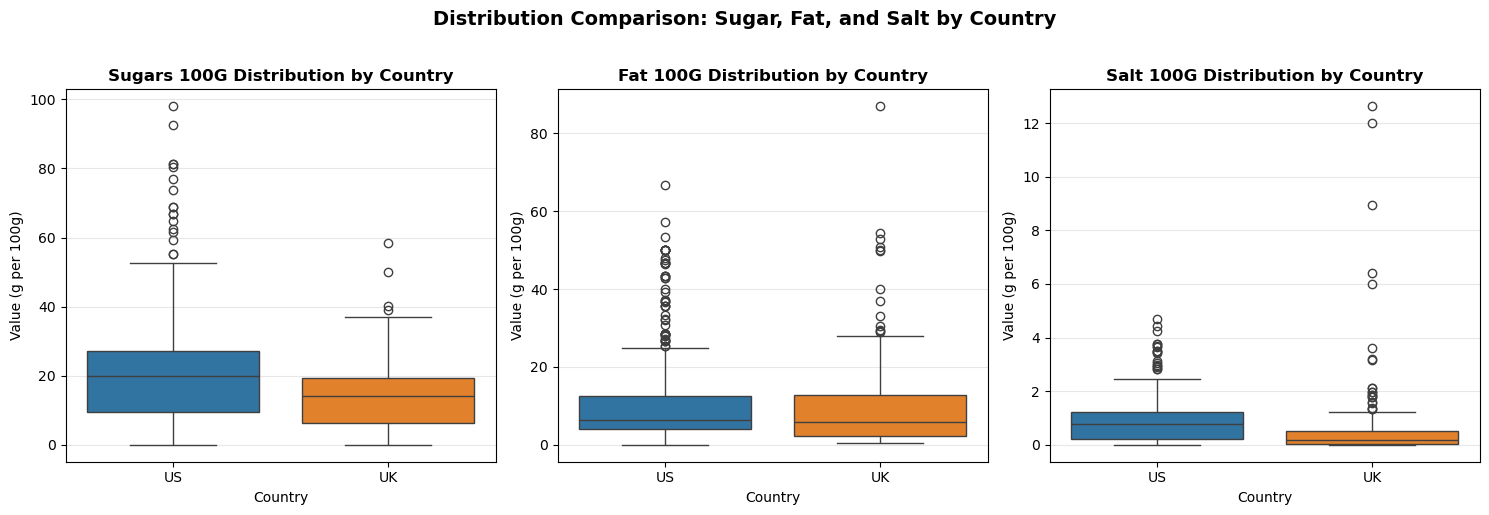

✓ Chart 1: Distribution comparison shows the dramatic difference in salt content!


In [26]:
# 1. Distribution Comparison (Box Plots)
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(['sugars_100g', 'fat_100g', 'salt_100g']):
    X_all = pd.concat([X_train, X_test])
    y_all = pd.concat([y_train, y_test])
    
    data_for_plot = pd.DataFrame({
        col: X_all[col],
        'Country': y_all
    })
    
    sns.boxplot(data=data_for_plot, x='Country', y=col, ax=axes[idx], palette=['#1f77b4', '#ff7f0e'])
    axes[idx].set_title(f'{col.replace("_", " ").title()} Distribution by Country', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Value (g per 100g)', fontsize=10)
    axes[idx].set_xlabel('Country', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Distribution Comparison: Sugar, Fat, and Salt by Country', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Chart 1: Distribution comparison shows the dramatic difference in salt content!")


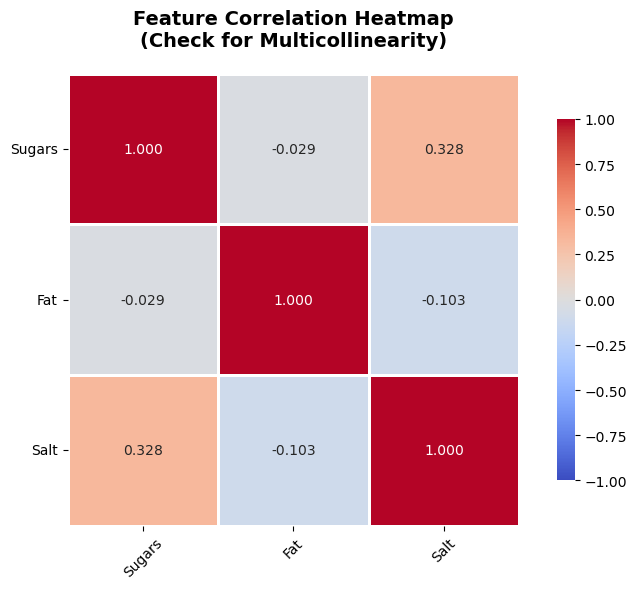

✓ Chart 2: Correlation heatmap
  - Strongest correlation: 0.328
  - Low correlations suggest minimal multicollinearity issues


In [27]:
# 2. Feature Correlation Heatmap
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate correlation matrix
corr_matrix = X_train[['sugars_100g', 'fat_100g', 'salt_100g']].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=2, cbar_kws={"shrink": 0.8}, 
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Feature Correlation Heatmap\n(Check for Multicollinearity)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticklabels([col.replace('_100g', '').title() for col in corr_matrix.columns], rotation=45)
ax.set_yticklabels([col.replace('_100g', '').title() for col in corr_matrix.columns], rotation=0)

plt.tight_layout()
plt.show()

print("✓ Chart 2: Correlation heatmap")
print(f"  - Strongest correlation: {corr_matrix.abs().where(~np.eye(3, dtype=bool)).max().max():.3f}")
print("  - Low correlations suggest minimal multicollinearity issues")
